# Intro

This Notebook documents a few investigations for modelling point and disk loads using analytic solutions to the equations of elastic equilibrium. These solutions are explained in detail in Farrell 1972 and also Chapter 3 of the book Contact Mechanics and given briefly here.

## Disk Load

For a disk load of unit weight (force), the solution for vertical displacement from Farrell 72 is:
    
\begin{equation}
u(0,r) =
    \begin{cases}
    -\frac{\sigma}{\pi^2\mu\eta \alpha} E\big(\frac{r}{
    \alpha} \big) & r < \alpha \\
    -\frac{\sigma r}{\pi^2\mu\eta \alpha^2} \Big\lbrack E\big(\frac{\alpha}{
    r}\big) - \big( 1 - \frac{\alpha^2}{r^2} K\big(\frac{\alpha}{r}\big) \Big\rbrack & r > \alpha
    \end{cases}
\end{equation}

where $E(x)$ and $K(x)$ are the complete elliptic integrals, which are special functions commonly tabulated (and included in scipy). As for constants, $\mu$ is the shear modulus, $\lambda$ is Lame's first parameter, $\eta = \mu + \lambda$ and $\alpha$ is the disk radius.

This scenario is also derived in Contact Mechanics, in terms of Young's Modulus and Poisson's Ratio, but I haven't gone through it in detail. The relationship between YM, Poisson's Ratio and Lame Parameters amongst more is here: ( or see SubSurf wiki if you don't have a magnifying glass to hand http://subsurfwiki.org/wiki/1st_Lam%C3%A9_parameter)

<img src="Conversion_Parameters.png">


## Point Load

For a point load, the solution from Farrel 72 is now obtainable for all z, not only z=0. It is:

\begin{equation}
u(z,r) = -\frac{1}{4 \pi \mu R} \big( \frac{\sigma}{\eta} + \frac{z^2}{R^2} \big)
\end{equation}

where $R = \sqrt{r^2 + z^2}$.

## Argus et al

Argus et al 2014 and 2017 use a more complicated formulation for a radially-stratified spherical Earth. They may even take into account graviational effects. However, we could expect the simple analytic solution detailed above to agree broadly with theirs. In their paper, they give two specific examples: loading from two 0.62 GT loads, one with a radius of 7 km and the other with a radius of 14 km.

<img src="Argus2014_result.png">





# Reproducing Argus et al 2014

I use the analytic model for a disk with the same radius and mass as Argus, and reproduce similar results to theirs. Note that to plot their result, I have picked results off their graph by hand.

In [1]:
%matplotlib inline

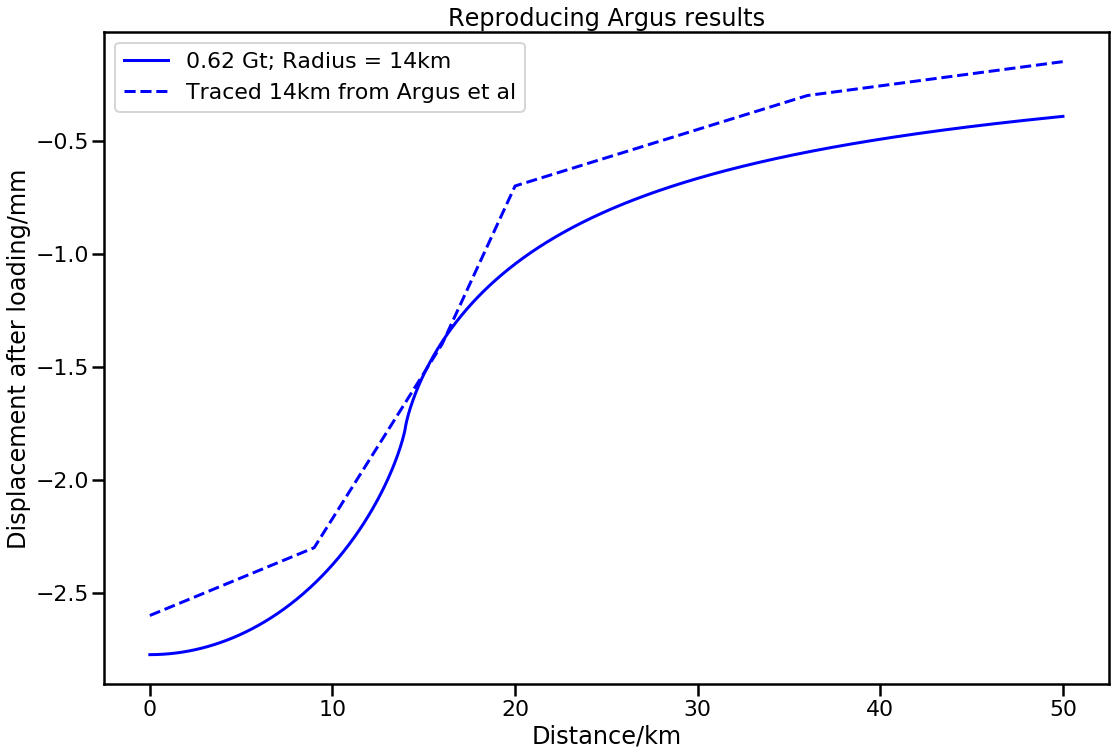

In [2]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import seaborn as sns

g = 9.81
lamda_gran = 25*10**9 # Lame parameter of granite
mew_gran = 40*10**9 # Shear modulus of granite


def calc_deformation_disk(M,lamda,mew,alpha,r):
    ''' 
    Calculates the deformation for a disk of mass M and radius alpha, on top of a substrate with Lame parameter lambda and shear modulus mew.
    M: mass of the disk, kg
    lamda: Lame parameter of substrate
    mew: shear modulus of substrate
    alpha: disk radius, in metres
    r: array of distances from centre of disk at which to calculate solution. In metres. eg r = np.linspace(0,50*10**3,num=1000) to go to 50km distance.
    
    '''
    sigma=lamda+2*mew
    nabla=lamda + mew
    
    defm=np.zeros_like(r)
    
    r_disk = r[r<=alpha]
    r_postdisk = r[r>=alpha]
    
    defm[r<=alpha]=-M*g* (sigma/(np.pi**2 * mew * nabla * alpha) * special.ellipe((r_disk/alpha)**2) )
    
    defm[r>=alpha]= -M *g* (sigma* r_postdisk / (np.pi**2 * mew * nabla * alpha**2)) * (special.ellipe((alpha/r_postdisk)**2) - (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)) 
    
    return defm




argus_traced_14_disp = -1*np.array([2.6, 2.3, 1.4, 0.7, 0.3, 0.15]) # These are the displacements which I picked by hand from Argus 2017
argus_traced_14_distance = [0,9,16,20,36,50] # And these are the corresponding distances in kilometres


M_Argus1 = np.pi * (14*10**3)**2 * 1 * 1000
#M_Argus2 = np.pi * (7*10**3)**2 * 4 * 1000
alpha_Argus1 = 14*10**3
#alpha_Argus2 = 7*10**3

r_argus = np.linspace(0,50*10**3,num=1000)

defm_Argus1 = calc_deformation_disk(M_Argus1,lamda_gran,mew_gran,alpha_Argus1,r_argus)
#defm_Argus2 = calc_deformation_disk(M_Argus2,lamda_gran,mew_gran,alpha_Argus2,r_argus)
sns.set_context('poster')

fig,ax = plt.subplots(1,1,figsize=(18,12))
plt.plot(r_argus/1000,defm_Argus1*1000,color='blue',label="0.62 Gt; Radius = 14km") 
plt.plot(argus_traced_14_distance,argus_traced_14_disp,'--',color='blue',label="Traced 14km from Argus et al")
#plt.plot(r_argus/1000,defm_Argus2*1000,color='orange',label="0.62 Gt; Radius = 7km") 
#plt.plot(point_Argusr/1000,pointloadArgus1*1000,label='Point Load Argus1')

plt.xlabel('Distance/km')
plt.ylabel('Displacement after loading/mm')

plt.title("Reproducing Argus results")


plt.legend()
plt.show()


# How deep are we sensitive to: case of point loading

BELOW HERE I HAVEN'T TIDIED UP; GENERALLY UNLABELLED AND TO BE LOOKED AT AT YOUR OWN RISK!


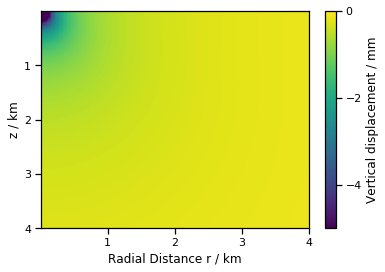

In [3]:




#
#
#defm_PineFlat = calc_deformation(M_Pine,lamda_gran,mew_gran,alpha,r)
#
#plt.plot(r/1000,defm_granite*1000,label="Granite Substrate")
#plt.plot(r/1000,defm_sandstone*1000,label="Sandstone Substrate")
#
#
#plt.xlabel('Distance/km')
#plt.ylabel('Displacement after loading/mm')
#
#plt.title("Modelled subsidence for Lake Kaweah")
#plt.legend()

#%%
sns.set_context('notebook')

def calc_deformation_point(R,Z,lamda,mew,M):
    sigma = lamda + 2*mew
    nabla = lamda + mew
    RR = np.sqrt(Z**2 + R**2)
    disp = -M/(4*np.pi*mew*RR) * (sigma/nabla + Z**2/RR**2)
    return disp

M_kaweah = 1.968*10**(11)
z = np.linspace(1,4000,num=200)
r_2d = np.linspace(1,4000,num=200)
R,Z = np.meshgrid(r_2d,z)
disp = calc_deformation_point(R,Z,lamda_gran,mew_gran,M_kaweah)

fig2= plt.figure()
plt.pcolormesh(R/1000,Z/1000,disp*1000,vmax=0,vmin=-5)
cbar = plt.colorbar()
cbar.set_label('Vertical displacement / mm')

plt.gca().invert_yaxis()
plt.xlabel('Radial Distance r / km')
plt.ylabel('z / km')

#%% Put the point load on the original plot

sns.set_context('poster')

pointload=disp[2,:]
point_r = R[2,:]


#ax.plot(point_r/1000,pointload*1000,label='Point Load')
fig.legend()




# How Important is Substrate

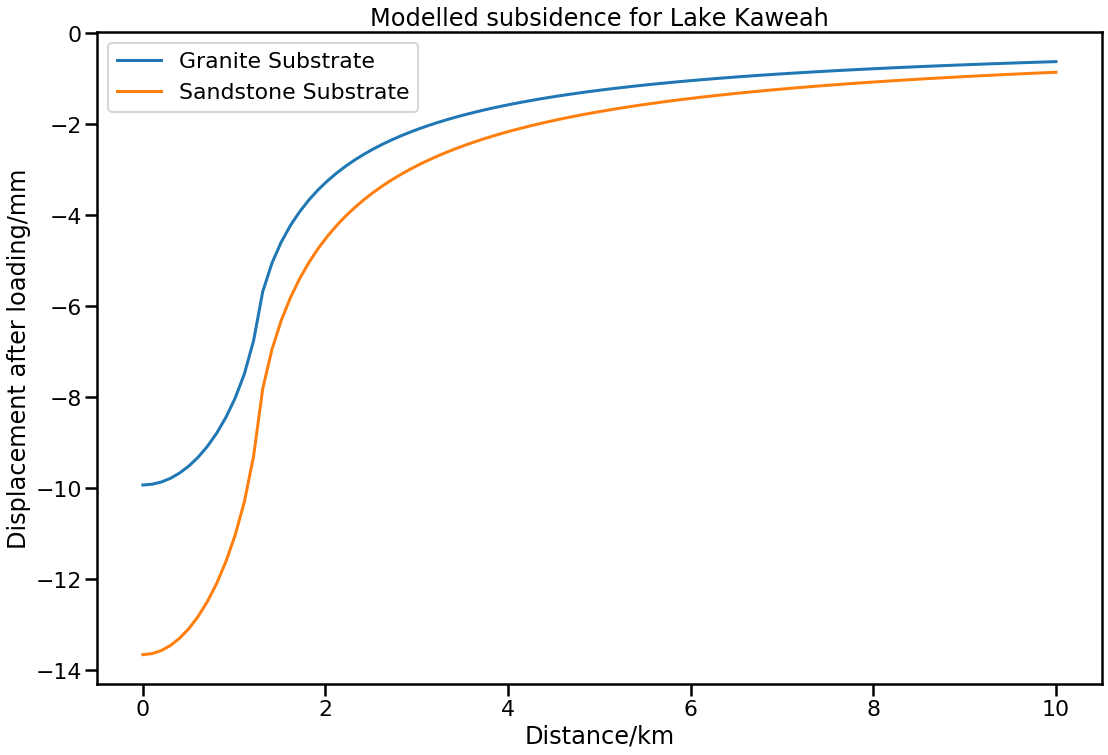

In [4]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import seaborn as sns

g = 9.81

M_kaweah = 1.968*10**(11)
lamda_gran = 25*10**9
lamda_sandstone = 15*10**9
lamda_uncons = 1*10**9

mew_gran = 40*10**9
mew_sandstone=30*10**9
mew_uncons = 1*10**9
r = np.linspace(0,10*10**3,num=100)
alpha = 1.25*10**3



def calc_deformation(M,lamda,mew,alpha,r):
    sigma=lamda+2*mew
    nabla=lamda + mew
    
    defm=np.zeros_like(r)
    
    r_disk = r[r<=alpha]
    r_postdisk = r[r>=alpha]
    
    defm[r<=alpha]=-M*g* (sigma/(np.pi**2 * mew * nabla * alpha) * special.ellipe((r_disk/alpha)**2) )
    
    defm[r>=alpha]= -M *g* (sigma* r_postdisk / (np.pi**2 * mew * nabla * alpha**2)) * (special.ellipe((alpha/r_postdisk)**2) - (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)) 
    
    return defm

#%%
sns.set_context('poster')

fig,ax = plt.subplots(1,1,figsize=(18,12))


defm_granite = calc_deformation(M_kaweah,lamda_gran,mew_gran,alpha,r)
defm_sandstone = calc_deformation(M_kaweah,lamda_sandstone,mew_sandstone,alpha,r)
defm_uncons = calc_deformation(M_kaweah,lamda_uncons,mew_uncons,alpha,r)

plt.plot(r/1000,defm_granite*1000,label="Granite Substrate")
plt.plot(r/1000,defm_sandstone*1000,label="Sandstone Substrate")
#plt.plot(r/1000,defm_uncons*1000,label="Unconsolidated Seds Substrate (??)")


plt.xlabel('Distance/km')
plt.ylabel('Displacement after loading/mm')

plt.title("Modelled subsidence for Lake Kaweah")

plt.legend()




In [5]:
#%% Check that I am using the right Lame parameters

Vp = 8000
Vs = 4200
rho = 2600

lamda_granite_Check = rho * (Vp**2 - 2*Vs**2)
mew_granite_Check = rho * Vs**2



In [6]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [7]:
def calc_deformation_2Ddisk(M,lamda,mew,alpha,R):
    ''' Calculates the deformation for a disk of mass M and radius alpha, on top of a substrate with Lame parameter lambda and shear modulus mew. R should be a meshgrid(r).'''
    sigma=lamda+2*mew
    nabla=lamda + mew
    
    defm=np.zeros_like(R)
    
    r_disk = r[r<=alpha]
    r_postdisk = r[r>=alpha]
    
    defm[r<=alpha]=-M*g* (sigma/(np.pi**2 * mew * nabla * alpha) * special.ellipe((r_disk/alpha)**2) )
    
    defm[r>=alpha]= -M *g* (sigma* r_postdisk / (np.pi**2 * mew * nabla * alpha**2)) * (special.ellipe((alpha/r_postdisk)**2) - (1 - (alpha/r_postdisk)**2) * special.ellipk((alpha/r_postdisk)**2)) 
    
    return defm


